# Model klasyfikacji opinii użytkowników

## Importowanie potrzebnych bibliotek

In [1]:
# podstawowe biblioteki
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.stats as stats
import seaborn as sns
# przygotwanie danych tekstowych
import re 
import lemminflect
from lemminflect import getLemma
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
# podstawowe statystyki
import collections
from collections import Counter
from wordcloud import WordCloud
# tworzenie modelu Bag-of-words
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
import gensim
# Podział zbioru (train, test)
from sklearn.model_selection import train_test_split
# Trenowanie modelu
import gensim
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel, CoherenceModel, LsiModel, HdpModel
import nltk
import pyLDAvis
import pyLDAvis.gensim_models
# Trenowanie modeli klasyfikacyjnych
from sklearn.naive_bayes import GaussianNB # Naive Bayes
from sklearn.linear_model import LogisticRegression # Logistic Regression
from sklearn.tree import DecisionTreeClassifier # Decision tree
from sklearn.ensemble import RandomForestClassifier # Random forest
from sklearn.svm import SVC # SVM and Kernel SVM
from sklearn.neighbors import KNeighborsClassifier # K-nearest neighbours
# Ocena modeli
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, precision_score, roc_auc_score, roc_curve

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Michał\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Importowanie zbioru danych

In [2]:
# oceny
# 1 - pozytywna
# 0 - neutralna
# -1 - negatywna

In [3]:
dataset = pd.read_csv('opineo_reviews.csv')
# źródło: https://github.com/Ermlab/pl-sentiment-analysis

In [4]:
dataset['rate'].unique()

array([ 1.,  0., -1., nan])

In [5]:
# Usunięcie braków danych oraz wartości zerowych
dataset.dropna(subset=['description'], inplace=True)  
dataset = dataset[dataset['description'] != ""]
dataset = dataset[dataset['description'] != " "] 

## Podstawowe statystyki

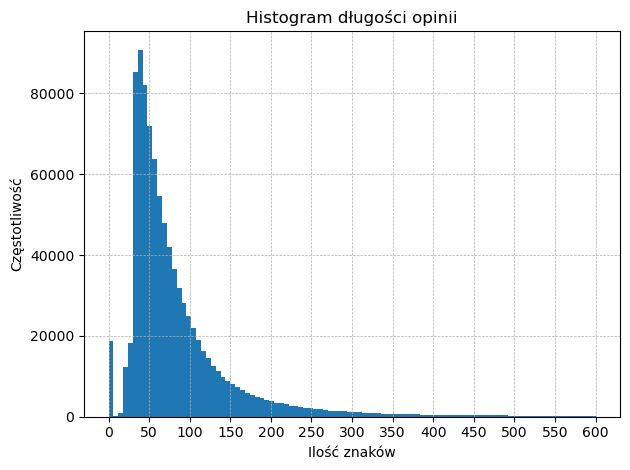

In [6]:
# histogram (długość opinii)
dataset['description'].str.len().hist(range = (0,600), bins = 100)
plt.xlabel('Ilość znaków')
plt.ylabel('Częstotliwość')
plt.title('Histogram długości opinii')
plt.xticks(range(0, 601, 50))  
plt.grid(which='both', linestyle='--', linewidth=0.5)  
plt.tight_layout()
plt.show()

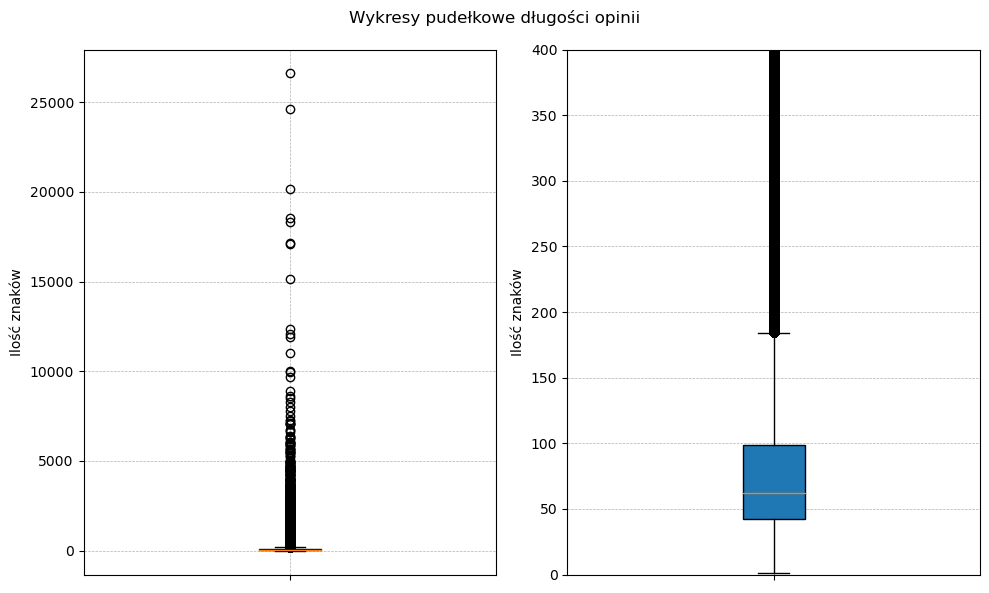

In [7]:
# wykresy pudełkowe długości opinii
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
fig.suptitle('Wykresy pudełkowe długości opinii')
# wykres pudełkowy
axes[0].boxplot(dataset['description'].str.len(), vert=True, patch_artist=True)
axes[0].set_ylabel('Ilość znaków')
axes[0].grid(which='both', linestyle='--', linewidth=0.5)
axes[0].set_xticklabels([])

# wykres pudełkowy z ograniczeniem osi Y
axes[1].boxplot(dataset['description'].str.len(), vert=True, patch_artist=True)
axes[1].set_ylabel('Ilość znaków')
axes[1].set_ylim(0, 400)
axes[1].grid(which='both', linestyle='--', linewidth=0.5)
axes[1].set_xticklabels([])


plt.tight_layout()
plt.show()

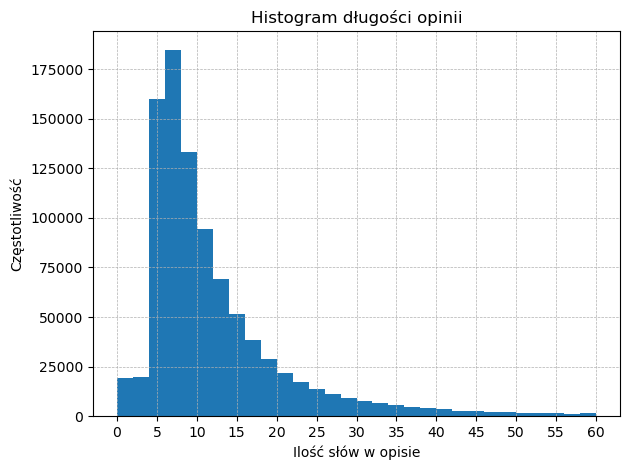

In [8]:
# Histogram (długość opinii w słowach)
dataset['description'].str.split().map(lambda x: len(x)).hist(range=(0, 60), bins=30)
plt.xlabel('Ilość słów w opisie')
plt.ylabel('Częstotliwość')
plt.xticks(range(0, 61, 5))  
plt.grid(which='both', linestyle='--', linewidth=0.5)  
plt.title('Histogram długości opinii')
plt.tight_layout()
plt.show()

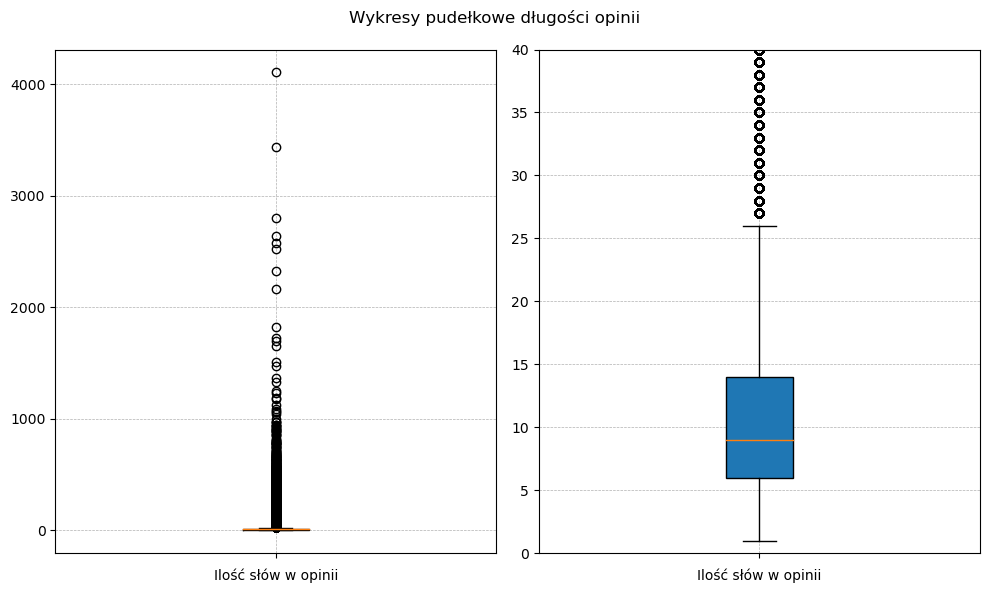

In [9]:
# wykresy pudełkowe długości opinii (ilość słów)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
fig.suptitle('Wykresy pudełkowe długości opinii')

# wykres pudełkowy
axes[0].boxplot(dataset['description'].str.split().map(lambda x: len(x)), vert=True)
axes[0].set_xlabel('Ilość słów w opinii')
axes[0].grid(which='both', linestyle='--', linewidth=0.5)
axes[0].set_xticklabels([])  

# wykres pudełkowy z ograniczeniem osi Y
axes[1].boxplot(dataset['description'].str.split().map(lambda x: len(x)), vert=True, patch_artist=True)
axes[1].set_xlabel('Ilość słów w opinii')
axes[1].set_ylim(0, 40)
axes[1].grid(which='both', linestyle='--', linewidth=0.5)
axes[1].set_xticklabels([])  

plt.tight_layout()
plt.show()

In [10]:
### statystyki: mediana, średnia, Q1, Q3, udział obserwacji odstających, wariacja, odchylenie standardowe, skośność rozkładu
# Kalkulacja ilości słów oraz znaków
dataset['ilość znaków'] = dataset['description'].str.len()
dataset['ilość słów'] = dataset['description'].str.split().map(lambda x: len(x))

# Kalkulacja podstawowych statystyk
stats_dict = {
    'statystyka': ['udział obserwacji odstających', 'pierwszy kwartyl (Q1)', 'średnia', 'mediana', 'trzeci kwartyl (Q3)', 'odchylenie standardowe', 'wariancja', 'współczynnik skośności'],
    'ilość znaków': [],
    'ilość słów': []
}

def calculate_statistics(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((column < (Q1 - 1.5 * IQR)) | (column > (Q3 + 1.5 * IQR))).sum()
    outlier_share = outliers / len(column)
    
    statistics = [
        outlier_share,  
        Q1,  
        column.mean(),  
        column.median(),  
        Q3,  
        column.std(),  
        column.var(),  
        stats.skew(column)  
    ]
    
    return statistics

stats_dict['ilość znaków'] = calculate_statistics(dataset['ilość znaków'])
stats_dict['ilość słów'] = calculate_statistics(dataset['ilość słów'])

# Dataframe z podstawowymi statystykami
stats_df = pd.DataFrame(stats_dict)

In [11]:
stats_df

,statystyka,ilość znaków,ilość słów
0,udział obserwacji odstających,0.079378,0.083535
1,pierwszy kwartyl (Q1),42.000000,6.000000
2,średnia,89.454492,12.952153
3,mediana,62.000000,9.000000
4,trzeci kwartyl (Q3),99.000000,14.000000
5,odchylenie standardowe,134.288368,20.118191
6,wariancja,18033.365736,404.741611
7,współczynnik skośności,45.272963,41.703454


In [12]:
# ilość pozytywnych, neutralnych i negatywnych opinii
opinie = {'opinia' : ['pozytywna','neutralna','negatywna'], 
          'ilość':  [dataset.query('rate == 1').shape[0], dataset.query('rate == 0').shape[0], dataset.query('rate == -1').shape[0]]}
reviews_nm = pd.DataFrame(opinie)

In [13]:
reviews_nm

,opinia,ilość
0,pozytywna,734250
1,neutralna,18547
2,negatywna,183391


## Przygotowanie danych (data pre-processing)

In [14]:
# plik txt z polskimi "stopwords"
with open('polishstopwords.txt', 'r', encoding='utf-8') as file:
    stopwords = file.readlines()

# usunięcie indykatora nowej linii (/n)
stopwords = [line.strip() for line in stopwords]
stopwords.remove('nie') # słowo 'nie' zostaje wykluczone z zbioru stopwords - jest to ważne słowo, które zmienia charakter opinii

In [21]:
# UWAGA: Zdecydowałem się na użycie stemmingu zamiast lemmatyzacji z powodu dużego rozmiaru zbioru danych. Stemming wymaga mniejszej mocy obliczeniowej i jest szybszy od lemmatyzacji. 
#(zastosowanie lemmatyzacji na tym zbiorze zajmuje około 3h :/ )
#corpus = []
#for i, row in tqdm(dataset.iterrows()):
#    review = str(dataset['description'][i])  # przekształcenie na klasę string
#    review = re.sub('[^a-zA-Z]+', ' ', review) # usunięcie nie-liter (kropka, przecinek, liczby, etc.) i zastąpienie ich spacją
#    review = review.lower() # transformacja na małe litery
#    # lemmatizing
#    review = [getLemma(word, upos='VERB')[0] if getLemma(word, upos='VERB') else word for word in review if word not in stopwords]  
#    review = ' '.join(review)
#    corpus.append(review)
    

In [23]:
corpus = []
for i, row in tqdm(dataset.iterrows()):
    review = str(dataset['description'][i]) # przekształcenie na klasę string
    review = re.sub('[^a-zA-Z]+', ' ', review) # usunięcie nie-liter (kropka, przecinek, liczby, etc.) i zastąpienie ich spacją
    review = review.lower() # transformacja na małe litery
    review = review.split() # rozbicie zdań na słowa
    ps = PorterStemmer()
    review = [ps.stem(word) for word in review if not word in set(stopwords)] # stemming
    review = ' '.join(review)
    corpus.append(review)

936254it [07:46, 2005.98it/s]


In [93]:
# tokenizacja (tokenization)
tokenized_corpus = [doc.split() for doc in corpus]

## Charakterystki słów

In [82]:
list_of_words = []
for x in corpus:
    words = x.split()
    for word in words:
        list_of_words.append(word)

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_d

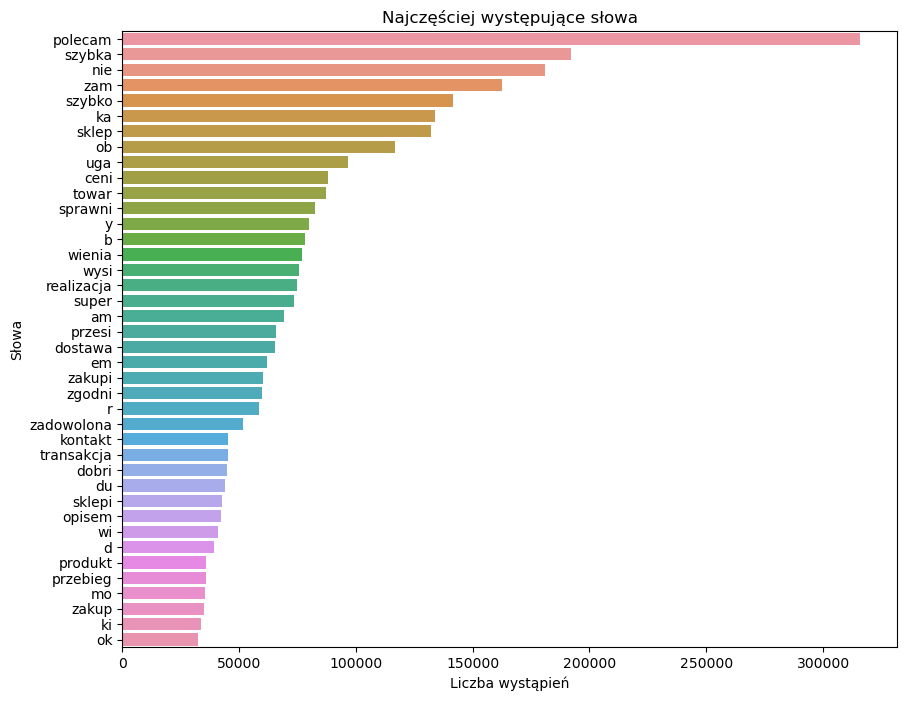

In [83]:
# częstotliwość występowania danych słów
counter = Counter(list_of_words)
most = counter.most_common()

x, y = [], []
for word, count in most[:40]:
    x.append(word)
    y.append(count)

# tworzenie wykresu
plt.figure(figsize=(10, 8))
sns.barplot(x=y, y=x)
plt.xlabel('Liczba wystąpień')
plt.ylabel('Słowa')
plt.title('Najczęściej występujące słowa')
plt.show()

In [74]:
# eksploracja najczęściej występujących "n-gramów" (gdzie "n" jest liczbą słów)
def get_top_ngram(corpuss, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpuss)
    bag_of_words = vec.transform(corpuss)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_d

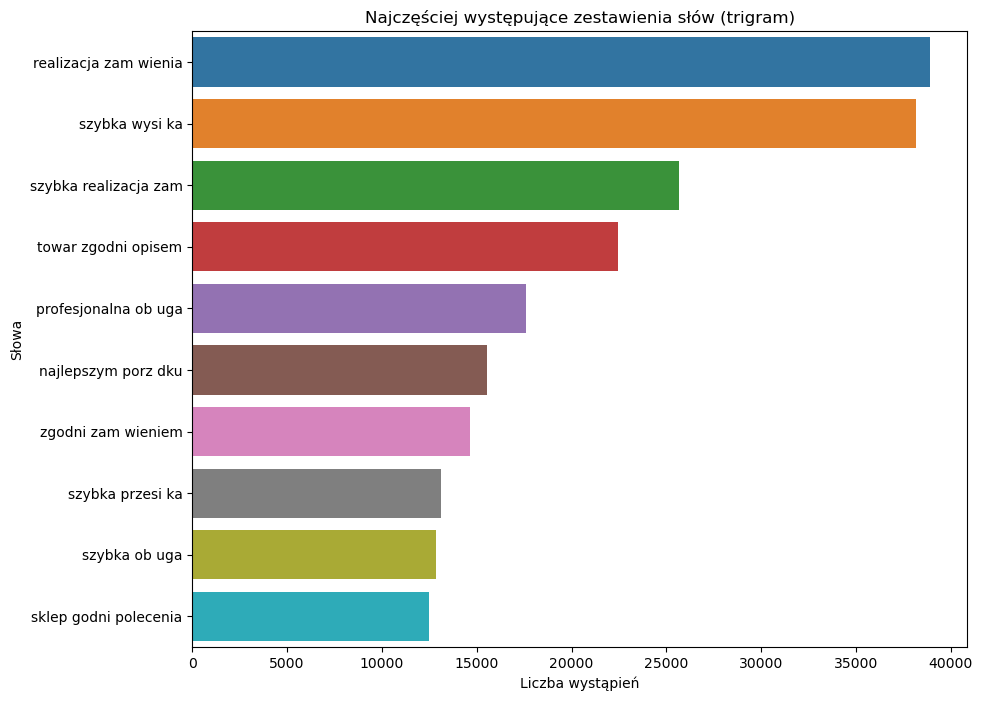

In [75]:
top_bi_grams=get_top_ngram(corpus,n=2)
x,y=map(list,zip(*top_tri_grams))
# wykres
plt.figure(figsize=(10, 8))
sns.barplot(x=y, y=x)
plt.xlabel('Liczba wystąpień')
plt.ylabel('Słowa')
plt.title('Najczęściej występujące zestawienia słów (trigram)')
plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_d

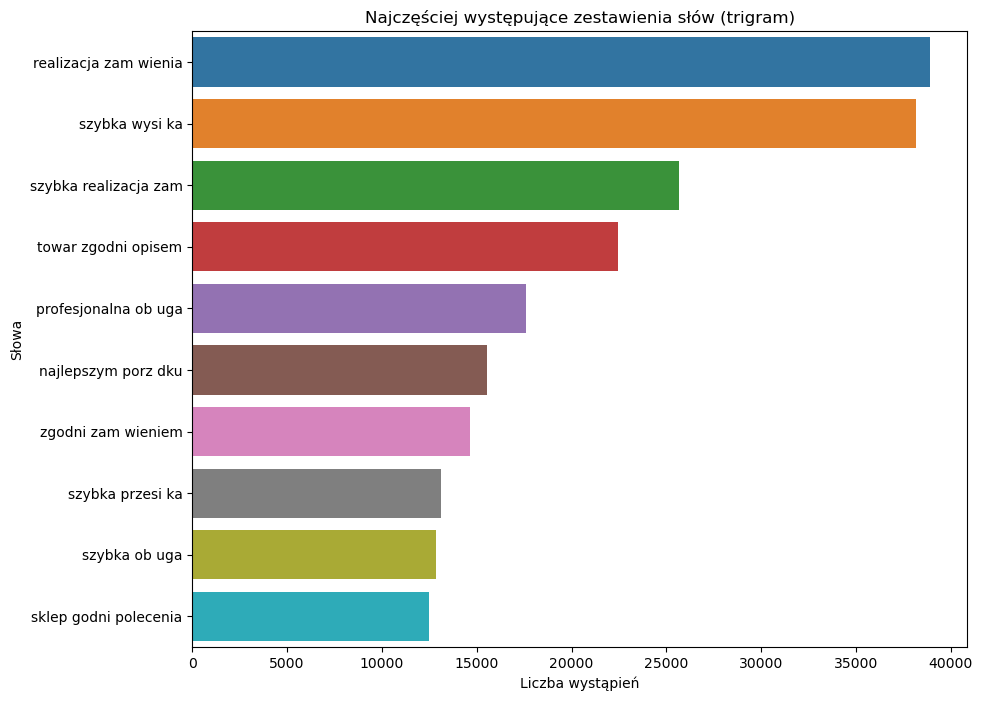

In [77]:
top_tri_grams=get_top_ngram(corpus,n=3)
x,y=map(list,zip(*top_tri_grams))
# wykres
plt.figure(figsize=(10, 8))
sns.barplot(x=y, y=x)
plt.xlabel('Liczba wystąpień')
plt.ylabel('Słowa')
plt.title('Najczęściej występujące zestawienia słów (trigram)')
plt.show()

## Modelowanie tematów (topic modelling)

### Bag of words 

In [95]:
dic=gensim.corpora.Dictionary(tokenized_corpus)
bow_corpus = [dic.doc2bow(doc) for doc in tokenized_corpus]

### Latent Dirichlet allocation model

In [107]:
lda_model = gensim.models.LdaMulticore(bow_corpus,
                                   num_topics = 40,
                                   id2word = dic,
                                    random_state=42,
                                    chunksize = 20000,
                                   passes = 3,
                                   workers = 2)

In [108]:
# wizualizacja modelu z użyciem biblioteki pyLDAvis
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dic)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
7      0.328095  0.041948       1        1  5.916458
4      0.291349  0.110255       2        1  5.181434
17    -0.183435  0.094612       3        1  4.960907
12     0.316552  0.040130       4        1  4.307520
39    -0.146244  0.030160       5        1  4.133793
33    -0.165898  0.225933       6        1  4.129209
35     0.008023  0.252683       7        1  4.071969
5      0.301202  0.047276       8        1  3.742030
2     -0.177471  0.038425       9        1  3.726456
29    -0.019989 -0.071755      10        1  3.654873
16     0.249453  0.002661      11        1  3.051494
22     0.088160  0.175134      12        1  2.933290
1      0.279726 -0.013411      13        1  2.772158
32    -0.176370 -0.048102      14        1  2.528297
31    -0.159455  0.172597      15        1  2.509824
3     -0.044686 -0.093677      16        1  2.504417
11     0.141947 -0.031424      17        1  2.399561
13     0.076282 -0.113985      18        1  2.388798
20    -0.235711  0.043975      19        1  2.291958
37     0.027425 -0.109799      20        1  2.227946
8     -0.106822 -0.022301      21        1  2.172949
9     -0.138166 -0.090269      22        1  2.002443
34     0.180358 -0.028773      23        1  1.917732
19     0.013150 -0.051396      24        1  1.889380
10    -0.087435 -0.011082      25        1  1.824659
38    -0.108798 -0.010710      26        1  1.819887
25    -0.073182  0.274675      27        1  1.777992
27    -0.111256 -0.019661      28        1  1.633249
18     0.047156 -0.008648      29        1  1.592554
21     0.026591 -0.054575      30        1  1.556605
24     0.005935 -0.109812      31        1  1.546226
6     -0.095143 -0.085229      32        1  1.467818
15    -0.034924 -0.074899      33        1  1.388774
36     0.000360 -0.117696      34        1  1.319908
14    -0.050882 -0.063809      35        1  1.300958
28    -0.085427 -0.054193      36        1  1.213415
26    -0.111385 -0.051738      37        1  1.203308
23    -0.015832 -0.061270      38        1  1.074555
0     -0.008879 -0.110931      39        1  1.056762
30    -0.044371 -0.041318      40        1  0.808434, topic_info=          Term           Freq          Total Category  logprob  loglift
0          nie  231100.000000  231100.000000  Default  30.0000  30.0000
43      szybko  127490.000000  127490.000000  Default  29.0000  29.0000
53          ka  139705.000000  139705.000000  Default  28.0000  28.0000
16         zam  153850.000000  153850.000000  Default  27.0000  27.0000
41          ob  112385.000000  112385.000000  Default  26.0000  26.0000
...        ...            ...            ...      ...      ...      ...
2735      dobi     449.034221     517.363049  Topic40  -5.1254   4.6762
841     przemi     763.487771    1654.357064  Topic40  -4.5946   4.0446
8        sklep    2164.228412  128112.687400  Topic40  -3.5527   0.7370
16         zam    1327.574016  153850.816633  Topic40  -4.0414   0.0652
601   produktu     745.205051    8015.545513  Topic40  -4.6189   2.4423

[2437 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
10293     32  0.991693    aaaa
20504     10  0.988641  absurd
1414       1  0.431827    abym
1414       2  0.072941    abym
1414       4  0.046986    abym
...      ...       ...     ...
217       35  0.001487   zwykl
217       37  0.000087   zwykl
217       38  0.920437   zwykl
18894     30  0.995275  zwykli
13059     16  0.993795   zyska

[10593 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 5, 18, 13, 40, 34, 36, 6, 3, 30, 17, 23, 2, 33, 32, 4, 12, 14, 21, 38, 9, 10, 35, 20, 11, 39, 26, 28, 19, 22, 25, 7, 16, 37, 15, 29, 27, 24, 1, 31])

#### Ewaluacja modelu oraz fine-tuning

In [112]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_corpus, dictionary=dic, coherence='c_v')
coherence_score_lda = coherence_model_lda.get_coherence()
print(f"Coherence Score: {coherence_score_lda}")

Coherence Score: 0.48914612499087873


In [116]:
number_of_topics = []
coherence = []

In [118]:
for x in tqdm(range(1,6)):
    number_of_topics.append(x)
    lda_model = gensim.models.LdaMulticore(bow_corpus,
                                   num_topics = x,
                                   id2word = dic,
                                    random_state=42,
                                    chunksize = 20000,
                                   passes = 3,
                                   workers = 2)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_corpus, dictionary=dic, coherence='c_v')
    coherence_score_lda = coherence_model_lda.get_coherence()
    coherence.append(coherence_score_lda)



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

 20%|████████████████▌                                                                  | 1/5 [02:15<09:01, 135.46s/it]

 40%|█████████████████████████████████▏                                                 | 2/5 [08:57<14:36, 292.03s/it]

 60%|█████████████████████████████████████████████████▊                                 | 3/5 [17:26<13:02, 391.20s/it]

 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [26:33<07:32, 452.62s/it]

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [35:25<00:00, 425.04s/it]


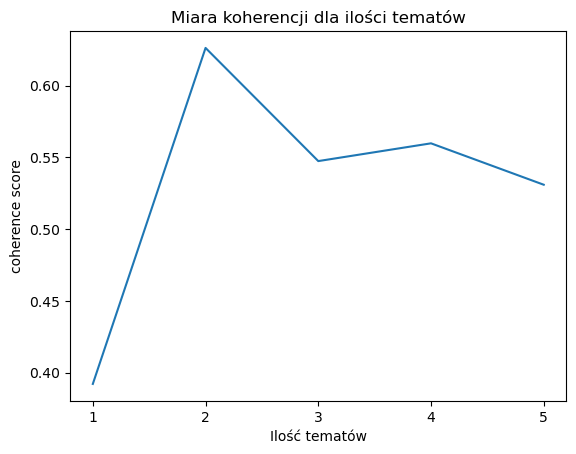

In [148]:
plt.plot(number_of_topics,coherence)
plt.xlabel('Ilość tematów')
plt.ylabel('coherence score')
plt.title('Miara koherencji dla ilości tematów')
plt.xticks([1,2,3,4,5])
plt.show()

In [131]:
# 2 tematy w modelu LDA`
lda_model = gensim.models.LdaMulticore(bow_corpus,
                                   num_topics = 2,
                                   id2word = dic,
                                    random_state=42,
                                    chunksize = 20000,
                                   passes = 3,
                                   workers = 2)

In [132]:
# wizualizacja
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dic)
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.246581  0.0       1        1  52.337699
1     -0.246581  0.0       2        1  47.662301, topic_info=       Term           Freq          Total Category  logprob  loglift
3   polecam  318536.000000  318536.000000  Default  30.0000  30.0000
0       nie  186407.000000  186407.000000  Default  29.0000  29.0000
88   szybka  188121.000000  188121.000000  Default  28.0000  28.0000
43   szybko  144472.000000  144472.000000  Default  27.0000  27.0000
41       ob  128247.000000  128247.000000  Default  26.0000  26.0000
..      ...            ...            ...      ...      ...      ...
31        b   30662.825649   76498.606035   Topic2  -4.9785  -0.1732
63       ki   13913.493497   26990.569594   Topic2  -5.7687   0.0784
96        r   17590.291857   55603.352046   Topic2  -5.5342  -0.4099
16      zam   19384.225567  151739.023001   Topic2  -5.4371  -1.3167
23   sklepi   11271.568984   38438.053457   Topic2  -5.9793  -0.4857

[152 rows x 6 columns], token_table=       Topic      Freq           Term
term                                 
58         1  0.014772             am
58         2  0.985237             am
31         1  0.599174              b
31         2  0.400831              b
157        1  0.999820  bezproblemowa
...      ...       ...            ...
155        2  0.001055         zgodni
1282       1  0.000451          zrobi
1282       2  0.999591          zrobi
26954      1  0.000173         zwierz
26954      2  0.999860         zwierz

[234 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [134]:
lda_model = gensim.models.LdaMulticore(bow_corpus,
                                   num_topics = 4,
                                   id2word = dic,
                                    random_state=42,
                                    chunksize = 20000,
                                   passes = 3,
                                   workers = 2)

In [135]:
# wizualizacja
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dic)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.329985  0.065121       1        1  34.388359
0     -0.227420 -0.085537       2        1  23.913574
3      0.052303 -0.182361       3        1  21.650006
2     -0.154868  0.202777       4        1  20.048061, topic_info=        Term           Freq          Total Category  logprob  loglift
16       zam  166564.000000  166564.000000  Default  30.0000  30.0000
43    szybko  141639.000000  141639.000000  Default  29.0000  29.0000
88    szybka  180640.000000  180640.000000  Default  28.0000  28.0000
3    polecam  310512.000000  310512.000000  Default  27.0000  27.0000
45       uga  102080.000000  102080.000000  Default  26.0000  26.0000
..       ...            ...            ...      ...      ...      ...
171    super   15019.115559   69939.566424   Topic4  -4.8262   0.0687
53        ka   15654.997976  123854.430754   Topic4  -4.7848  -0.4613
31         b   12152.192990   76012.030431   Topic4  -5.0380  -0.2263
55   produkt    8796.125672   33614.553873   Topic4  -5.3612   0.2664
291  dostawa    9281.887214   61338.714375   Topic4  -5.3075  -0.2813

[319 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
5210       4  0.993558  aktualnym
58         1  0.365855         am
58         2  0.000171         am
58         3  0.550702         am
58         4  0.083277         am
...      ...       ...        ...
1282       1  0.816109      zrobi
1282       3  0.183799      zrobi
1282       4  0.000078      zrobi
26954      1  0.999562     zwierz
26954      3  0.000402     zwierz

[806 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 4, 3])

##### LSI model

In [139]:
# trenowanie modelu LSI
import warnings
warnings.filterwarnings('ignore')
lsi_model = LsiModel(corpus=bow_corpus, id2word=dic, num_topics=4)

In [145]:
# ewaluacja modelu
coherence_model_lsi = CoherenceModel(model=lsi_model, texts=tokenized_corpus, dictionary=dic, coherence='c_v')
coherence_score_lsi = coherence_model_lsi.get_coherence()
print(f"Coherence Score: {coherence_score_lsi}")

Coherence Score: 0.6155947489782778


##### HDP model

In [146]:
# trenowanie modelu HDP
hdp_model = HdpModel(corpus=bow_corpus, id2word=dic)

In [147]:
# ewaluacja modelu
coherence_model_hdp = CoherenceModel(model=hdp_model, texts=tokenized_corpus, dictionary=dic, coherence='c_v')
coherence_score_hdp = coherence_model_hdp.get_coherence()
print(f"Coherence Score: {coherence_score_hdp}")

Coherence Score: 0.386349451058287
